## 1. Importing required modules

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
#sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [2]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


## 2. Preparing the data
### 2.1 Making the functions to get the training and validation set from the Images

In [3]:
X = []
Z = []
IMG_SIZE = 30
classes = 43

In [4]:
def make_train_data(classes):
    for i in range(classes):
        path = "../input/gtsrb-german-traffic-sign/Train/{}/".format(i)
        class_image = os.listdir(path)
        for j in class_image:
            img = cv2.imread(path+j, cv2.IMREAD_COLOR)
            train_image_from_array = Image.fromarray(img, 'RGB')
            train_label = int(i)
            if train_image_from_array is not None:
                resized_train_img = train_image_from_array.resize((IMG_SIZE,IMG_SIZE))
                X.append(np.array(resized_train_img))
                Z.append(train_label)

In [5]:
make_train_data(classes)

In [6]:
print(len(X))
print(len(Z))

39209
39209


### 2.2 Visualizing random images

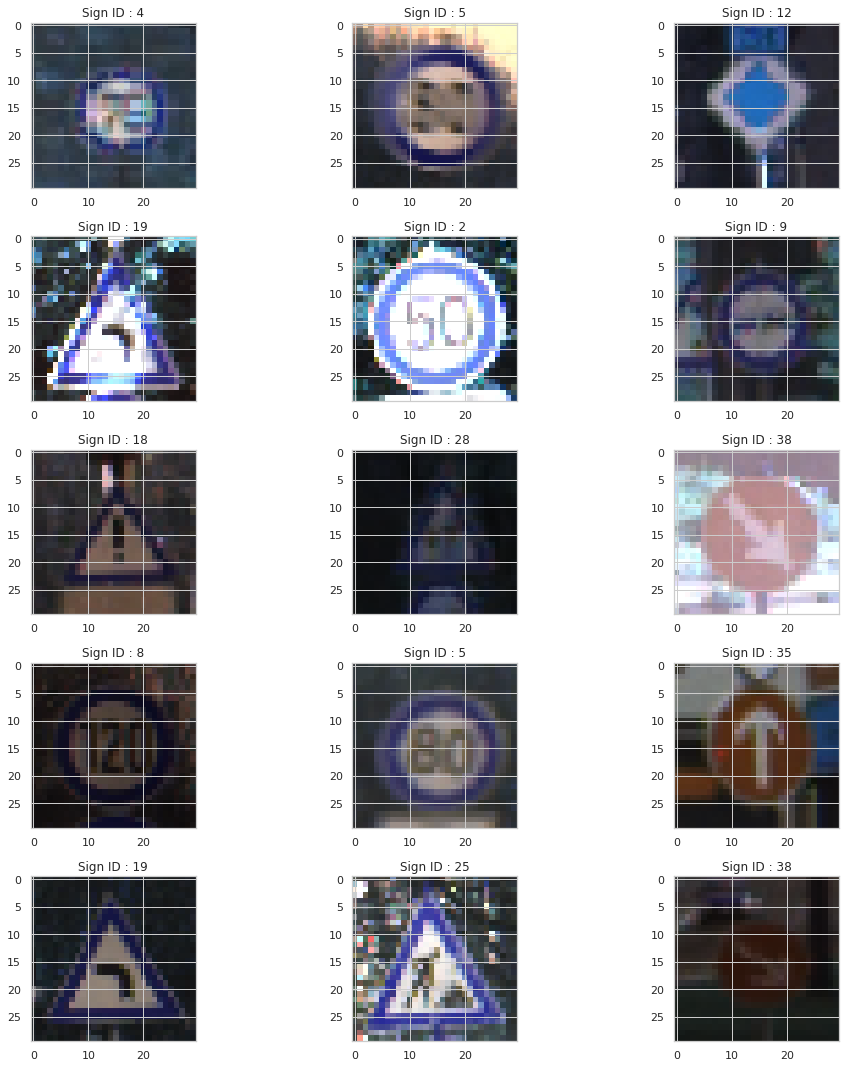

In [7]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(3):
        l = rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Sign ID : '+ str(Z[l]))
        
plt.tight_layout()

### 2.3 Label Encoding the Y array & then One Hot Encoding

In [8]:
le = LabelEncoder()
Y = le.fit(Z)
Y = le.transform(Z)
Y = to_categorical(Y, classes)
X = np.array(X)
X = X / 255

In [9]:
print("Shape of X:{}".format(X.shape))
print("Shape of Y:{}".format(Y.shape))

Shape of X:(39209, 30, 30, 3)
Shape of Y:(39209, 43)


### 2.4 Splitting into Training and Validation Sets

In [10]:
x_train,x_val,y_train,y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

In [11]:
print("Shape of x_train:{}".format(x_train.shape))
print("Shape of y_train:{}".format(y_train.shape))
print("Shape of x_val:{}".format(x_val.shape))
print("Shape of y_val:{}".format(y_val.shape))

Shape of x_train:(29406, 30, 30, 3)
Shape of y_train:(29406, 43)
Shape of x_val:(9803, 30, 30, 3)
Shape of y_val:(9803, 43)


### 2.5 Setting the random seeds

In [12]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## 3. Building the model
### 3.1 Specifying the VGG-16 model in Keras

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))


model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))



model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

model.add(Conv2D(filters=128, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

model.add(Conv2D(filters=128, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))



model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Dropout(rate=0.25))

# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))



# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
# model.add(Dropout(rate=0.25))

# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

# model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))



model.add(Flatten())

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(43, activation='softmax'))

### 3.2 Using LR annealer

In [14]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(x_train)
red_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)

### 3.3 Specifying the bacth size and epochs and then compiling the model.

In [15]:

batch_size=128
epochs=20
#model.compile(optimizer=SGD(lr=0.01, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy']) # Original VGG Parameters
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

### 3.4 Model summary

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

### 3.5 Training the model and making predictions on the validation set.

In [17]:
# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs=epochs, validation_data = (x_val,y_val),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // 128, callbacks=[red_lr])

History = model.fit(x_train,y_train, batch_size=batch_size,
                              epochs=epochs, validation_data = (x_val,y_val),
                              verbose = 1, callbacks=[red_lr])

Train on 29406 samples, validate on 9803 samples
Epoch 1/20
29406/29406 [==============================] - 11s 357us/step - loss: 3.1322 - accuracy: 0.1276 - val_loss: 1.8843 - val_accuracy: 0.3983
Epoch 2/20
29406/29406 [==============================] - 6s 189us/step - loss: 1.3871 - accuracy: 0.5282 - val_loss: 0.6873 - val_accuracy: 0.7547
Epoch 3/20
29406/29406 [==============================] - 6s 188us/step - loss: 0.6041 - accuracy: 0.7950 - val_loss: 0.2396 - val_accuracy: 0.9225
Epoch 4/20
29406/29406 [==============================] - 6s 191us/step - loss: 0.3053 - accuracy: 0.8990 - val_loss: 0.1228 - val_accuracy: 0.9607
Epoch 5/20
29406/29406 [==============================] - 6s 193us/step - loss: 0.1847 - accuracy: 0.9405 - val_loss: 0.0964 - val_accuracy: 0.9684
Epoch 6/20
29406/29406 [==============================] - 6s 200us/step - loss: 0.1543 - accuracy: 0.9526 - val_loss: 0.0579 - val_accuracy: 0.9815
Epoch 7/20
29406/29406 [==============================] - 6s 1

## 4.  Plotting and evaluating the model performance
### 4.1 Accuracy graph against the number of epochs

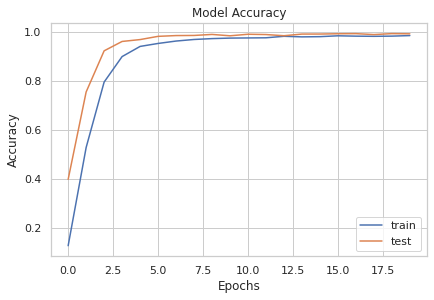

In [18]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### 4.2 Loss function graph against number of epochs

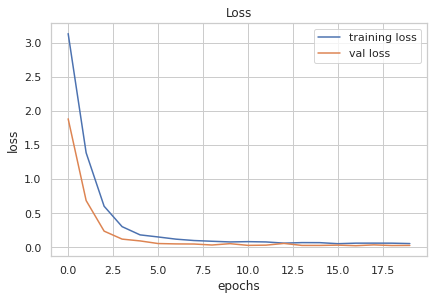

In [19]:
plt.figure(1)
plt.plot(History.history['loss'], label='training loss')
plt.plot(History.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

## 5. Visualizing Predictons on the Validation Set

In [20]:
#Predicting with the test data
import pandas as pd
y_test=pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]
for f in labels:
    image=cv2.imread('../input/gtsrb-german-traffic-sign/test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((IMG_SIZE, IMG_SIZE))
    data.append(np.array(size_image))

x_test=np.array(data)
x_test = x_test.astype('float32')/255 
pred = model.predict_classes(x_test)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9622327790973871

## 6. Calculating number of correctly and incorrectly classified number of images.

In [22]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(y_test[i] == pred[i]):
        prop_class.append(i)
        

for i in range(len(y_test)):
    if(y_test[i] != pred[i]):
        mis_class.append(i)

print("Number of test images: {}".format(len(y_test)))        
print("Number of correctly classified images: %d" %(len(prop_class)))
print("Number of incorrectly classified images: %d" %(len(mis_class)))

Number of test images: 12630
Number of correctly classified images: 12153
Number of incorrectly classified images: 477


## 7. Correctly classified images visualized

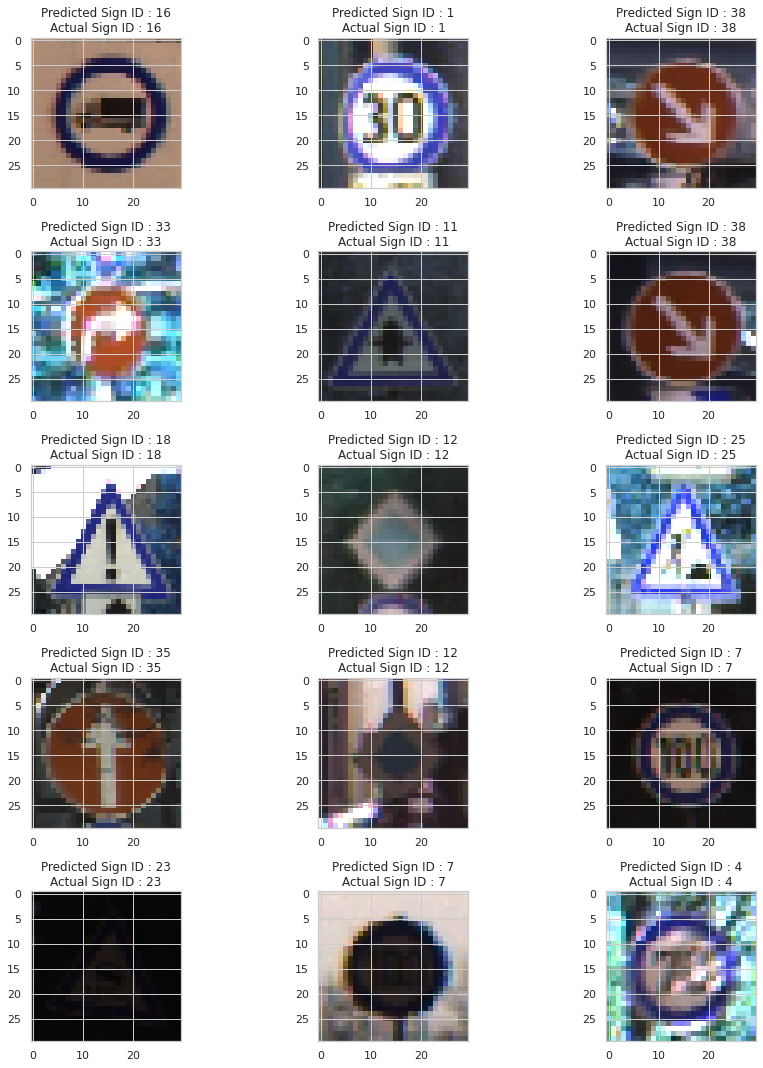

In [23]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
count=0
for i in range(5):
    for j in range(3):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Sign ID : "+str(pred[prop_class[count]])+"\n"+"Actual Sign ID : "+str(y_test[prop_class[count]]))
        plt.tight_layout()
        count+=1

## 8. Incorrectly classified images visualized

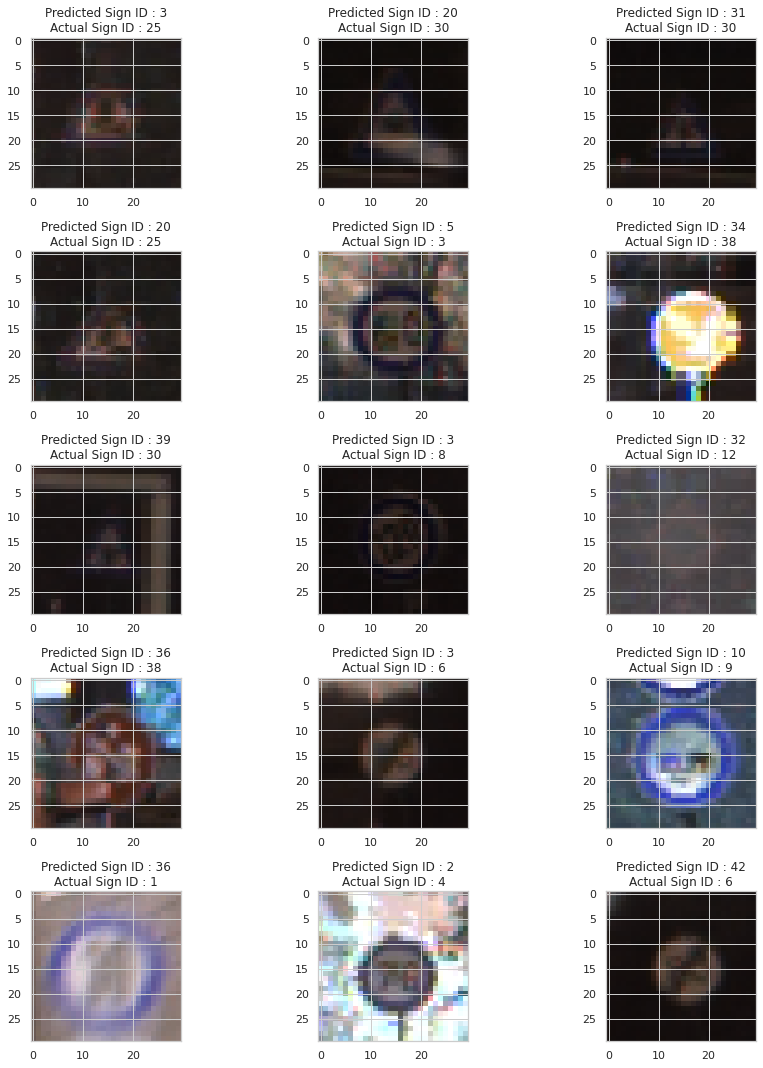

In [24]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
count=0
for i in range(5):
    for j in range(3):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Sign ID : "+str(pred[mis_class[count]])+"\n"+"Actual Sign ID : "+str(y_test[mis_class[count]]))
        plt.tight_layout()
        count+=1